<a href="https://colab.research.google.com/github/TKeitacw/Transfer_Nets/blob/main/Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/TKeitacw/Transfer_Nets.git

Cloning into 'Transfer_Nets'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [3]:
import torch
from torch import nn
from torchvision import models
from torch.nn.modules.container import Sequential
from Transfer_Nets.Transfer_Net import Transfer_Net

from torchsummary import summary

model = Transfer_Net({"model":"alexnet", "trainable_layer":(torch.nn.modules.BatchNorm2d,)}).cuda()



In [ ]:
#@title ## Download and extract data zipfile

# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division
import warnings
warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from collections import OrderedDict
import glob
from PIL import Image

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip -dq ./

ants = glob.glob('./hymenoptera_data/train/ants/*')
bees = glob.glob('./hymenoptera_data/train/bees/*')
f=lambda x: np.array(Image.open(x))
ants = np.array(list(map(f,ants)))
bees = np.array(list(map(f,bees)))
data = np.concatenate((ants,bees),0)
labels = np.concatenate((np.zeros(len(ants)),np.ones(len(bees))),0).astype('int64')

ants_val = glob.glob('./hymenoptera_data/train/ants/*')
bees_val = glob.glob('./hymenoptera_data/train/bees/*')
f=lambda x: np.array(Image.open(x))
ants_val = np.array(list(map(f,ants_val)))
bees_val = np.array(list(map(f,bees_val)))
data_val = np.concatenate((ants_val,bees_val),0)
labels = np.concatenate((np.zeros(len(ants_val)),np.ones(len(bees_val))),0).astype('int64')

In [5]:
# making dataloader
# Data augmentation and normalization for training
# Just normalization for validation
from torchvision import transforms, datasets
import os
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

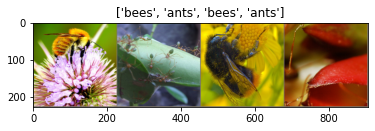

In [6]:
#@title define some funciton to visualize inputs.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [44]:
#@title ## Define some function(training, printing result)
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm as tsn
from matplotlib import cm as cmap
# x[H,W]
def toColorImg(x, cm='bwr_r', maxabs=None):
    if maxabs==None:
        maxabs = x.abs().max()
    norm = tsn(vmin=np.minimum(-maxabs,-1e-6), vcenter=0, vmax=np.maximum(maxabs,1e-6)) # maps[channels]
    sm = cmap.ScalarMappable(norm=norm, cmap=cm)
    return sm.to_rgba(x)[:,:,:3]

In [8]:
from torchsummary import summary
model = Transfer_Net({"model":"resnet18"}).cuda()
summary(model, (3, 224,224))
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
# Train model!
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6331 Acc: 0.6598
val Loss: 0.3226 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4761 Acc: 0.7869
val Loss: 0.2381 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4203 Acc: 0.8033
val Loss: 0.1844 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.5884 Acc: 0.7459
val Loss: 0.3883 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.6241 Acc: 0.7664
val Loss: 0.3154 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.4156 Acc: 0.8074
val Loss: 0.3954 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.3328 Acc: 0.8484
val Loss: 0.3212 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.4500 Acc: 0.8320
val Loss: 0.1911 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3960 Acc: 0.8320
val Loss: 0.2024 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3405 Acc: 0.8566
val Loss: 0.1841 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3695 Acc: 0.8443
val Loss: 0.1900 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3123 Acc: 0.8730
val Loss: 0.2017 Acc: 0.9477

Ep

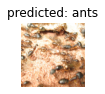

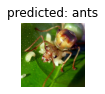

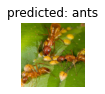

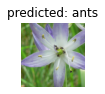

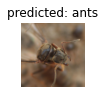

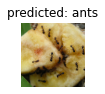

In [10]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [68]:
model_ft.instance_CAMlayer()
sig = torch.nn.Sigmoid()
input, label = next(iter(dataloaders['val']))
pred, cam = model_ft.forward_withCAM(input.cuda())
pred = sig(pred)
prediction = torch.max(pred, 1)[1]
cam = cam.detach().cpu()

mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
input = std * input + mean
input = np.clip(input.permute(0,2,3,1).numpy(), 0, 1)


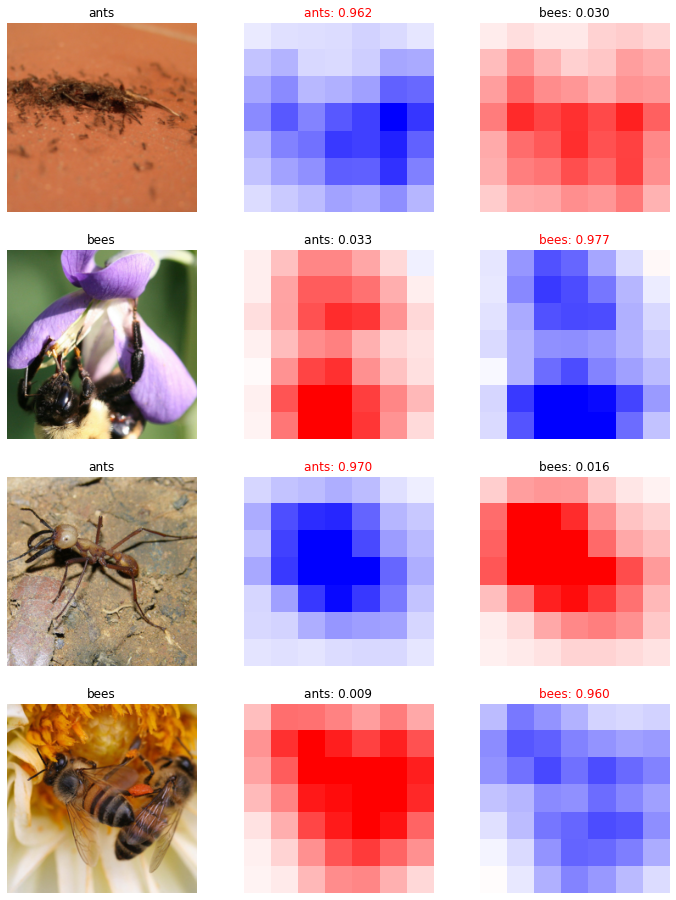

In [69]:
fig = plt.figure(figsize=(12,4*4))
dic_label = {0:"ants",
                  1:"bees"}
for i in range(4):
    plt.subplot(4,3,3*i+1)
    plt.imshow(input[i])
    plt.axis('off')
    plt.title(dic_label[label[i].item()])
    plt.subplot(4,3,3*i+2)
    plt.imshow(toColorImg(cam[i][0].detach().cpu(), maxabs=cam[0].max().item()))
    plt.title("ants: {:.3f}".format(pred[i][0].item()), color="red" if prediction[i]==0 else "black")
    plt.axis('off')
    plt.subplot(4,3,3*i+3)
    plt.imshow(toColorImg(cam[i][1].detach().cpu(), maxabs=cam[0].max().item()))
    plt.title("bees: {:.3f}".format(pred[i][1].item()), color="red" if prediction[i]==1 else "black")
    plt.axis('off')